# Just playing with Gaussian Mixture Model to understand the EM-Algorithm

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import dirichlet
from scipy.stats import multinomial
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.animation

%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
class GM():

    def __init__(self, mean=[0], cov=[1]):
        self.dim = np.array(mean).shape[0]
        self.reg_cov = (1e-6) * np.identity(self.dim)

        self.mean = mean
        self.cov = cov + self.reg_cov
        


    def likelihood(self, x):
        return multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)

    def log_likelihood(self, x):
        return np.log(multivariate_normal.pdf(x, mean=self.mean, cov=self.cov))

    def sample(self, size=1):
        sample = multivariate_normal.rvs(mean=self.mean, cov=self.cov, size=size)
        if size == 1:   return np.expand_dims(sample, axis=0)
        else:           return sample
    
    # Inspiration was taken from
    # [https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html]
    def plot(self, ax, n_std=3.0, facecolor='none', **kwargs):
        if not self.dim == 2 : 
            raise Exception('Plot requires 2d distributions')

        pearson = self.cov[0, 1] / np.sqrt(self.cov[0, 0] * self.cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)

        mean_x = self.mean[0]
        scale_x = np.sqrt(self.cov[0, 0]) * n_std
        
        mean_y = self.mean[1]
        scale_y = np.sqrt(self.cov[1, 1]) * n_std

        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)

        ellipse.set_transform(transf + ax.transData)

        ax.add_patch(ellipse)

In [3]:
class GMM(): 
    
    def __init__(self, k, dim=2, pi=None, means=None, covs=None):

        self.dim = dim
        self.k = k

        if pi is None: 
            self.pi = dirichlet.rvs(np.ones(k), size=1)[0]

        if means is None: 
            self.means = norm.rvs(loc=0, scale=10, size=(k,dim))
        
        if covs is None: 
            self.covs = np.apply_along_axis(
                np.diag, 1, np.abs(norm.rvs(loc=0, scale=10, size=(k,dim))) + 1
            )

        self.dists = []
        for (mean, cov) in zip(self.means, self.covs):
            self.dists.append(GM(mean, cov))

    def set_dists(self, pi, means, covs):
        self.pi = pi
        self.means = means
        self.covs = covs 
        
        self.dists = []
        for (mean, cov) in zip(self.means, self.covs):
            self.dists.append(GM(mean, cov))

    def log_likelihood(self, xs):
        log_likelihood = 0

        for x in xs: 
            likelihoods = np.array(list(map(lambda dist: dist.likelihood(x), self.dists)))
            log_likelihood += np.log(np.sum(self.pi * likelihoods))

        return log_likelihood

    def sample(self, size=1, comp=False):

        res = np.array([]).reshape((-1, self.dim + int(comp)))

        for _ in range(size):
            com = np.where(multinomial.rvs(n=1, p=self.pi) == 1)[0][0]
            sample = self.dists[com].sample()
            label = np.tile([com], (1,1))
            sample = np.append(sample, label, axis=1)
            res = np.append(res, sample, axis=0)

        return res

    def plot(self, ax, n_std=3.0, facecolor='none', **kwargs):
        if not self.dim == 2: 
            raise Exception('Plot requires 2d distributions')

        for dist in self.dists: 
            dist.plot(ax, n_std=n_std, facecolor=facecolor, **kwargs)


    def fit(self, data, iter=5):
        
        data = data[:, :2]
        len_data = data.shape[0]

        def E_step():
            tau = np.zeros( (self.k, len_data) )

            for i in range(len_data):
                den = np.sum(
                        self.pi 
                        * np.array(list(
                            map(
                                lambda dist: dist.likelihood(data[i]), 
                                self.dists
                            )
                        ))
                    )
                for k in range(self.k): 
                    tau[k,i] = self.pi[k] * self.dists[k].likelihood(data[i]) / den 

            return tau
        
        def M_step(tau):
            
            new_pi = np.sum(tau, axis=1) / len_data

            new_means = np.zeros_like(self.means)
            for i in range(self.dim): 
                new_means[:,i] = np.sum(tau * data[:,i].T, axis=1) / np.sum(tau, axis=1)

            new_covs = np.zeros_like(self.covs)
            data_c = (np.tile(np.expand_dims(data, axis=1), (self.k,1)) - new_means)
            for i in range(self.dim): 
                for j in range(self.dim): 
                    new_covs[:,i,j] = np.sum(tau * data_c[:,:,i].T * data_c[:,:,j].T, axis=1) / np.sum(tau, axis=1)

            return new_pi, new_means, new_covs

        for _ in range(iter): 
            pi, means, covs = M_step(E_step())
            self.set_dists(pi, means, covs)

-3232.664702769731


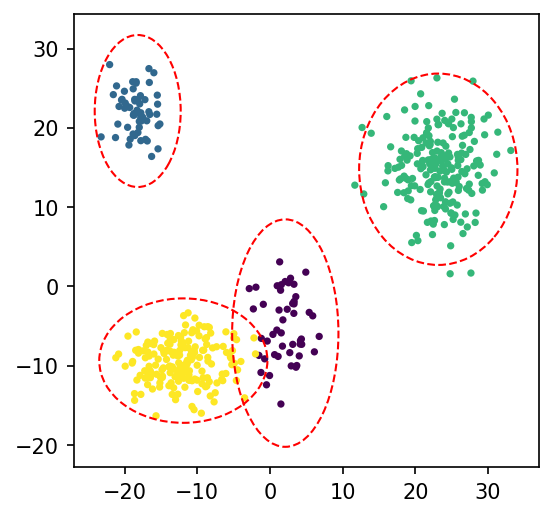

In [7]:
gmm = GMM(4)
sample = gmm.sample(size=500, comp=True)
print(gmm.log_likelihood(sample[:, :2]))

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample[:, 0], sample[:, 1], c=sample[:, 2], marker='.', s=25)
gmm.plot(ax, edgecolor='red', linestyle='--')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

Initial log-likelohood:  -9353.527425809594


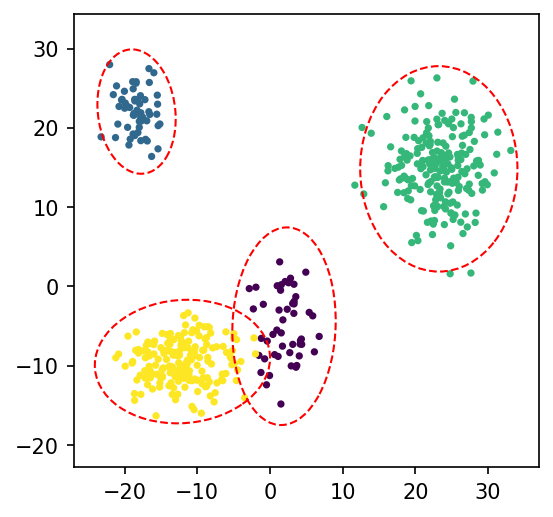

In [14]:
gmm = GMM(4)
print("Initial log-likelohood: ", gmm.log_likelihood(sample[:, :2]))

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)

def animate(t):
    ax.clear()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.scatter(sample[:, 0], sample[:, 1], c=sample[:, 2], marker='.', s=25)
    gmm.plot(ax, edgecolor='red', linestyle='--')
    gmm.fit(sample, iter=1)
    
matplotlib.animation.FuncAnimation(fig, animate, frames=50)